# Multi-Template matching 
## Tutorial 2 : template "augmentation"

In this tutorial we will use the multi-template matching to localize fish embryos in wells of a 96 well plate.  
The embryos are circular and thus their position and orientation is completely random. Therefore using a single template might not allow to localize all the specimen.  
The good news is that we can simply use more templates to catch more variability.     

We are going to use a published dataset available on Zenodo (thanks Jakob ;) )  
Just click the DOI badge below.
 [![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.2650147.svg)](https://doi.org/10.5281/zenodo.2650147)
 
 ----------------------------------------
 
<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />This tutorial is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.  
You are free to distribute and/or modify this tutorial, provided you attribute the author:  

Multi-Template Matching python package online tutorial - _Tutorial 2: Template Augmentation_  
Laurent Thomas - 2019   
https://github.com/multi-template-matching/MultiTemplateMatching-Python/blob/master/tutorials/Tutorial2-Template_Augmentation.ipynb

## Let's code !

In [2]:
# Go to root folder of the repo
%cd ..

C:\Users\Laurent Thomas\Documents\repo-MTM-Python


In [11]:
# 1st import the package and check its version
import MTM
print("MTM version : ", MTM.__version__)

from MTM import matchTemplates, drawBoxesOnRGB
from MTM.NMS import NMS

import cv2
print("Opencv version: ", cv2.__version__)
from skimage import io
import matplotlib.pyplot as plt
import numpy as np

MTM version :  1.5.4
Opencv version:  4.3.0


Let's open one image from the Zenodo repo using scikit-image

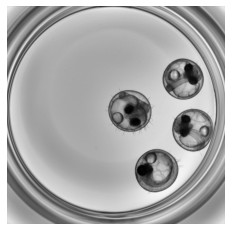

In [4]:
URL = r"https://zenodo.org/record/2650147/files/WE00049---E001--PO01--LO001--CO6--00000000_00.01.00_00.16.00%2C000.jpg"
image = io.imread(URL)
plt.axis("off")
plt.imshow(image, cmap="gray")

Let's crop one embryo to use as a template

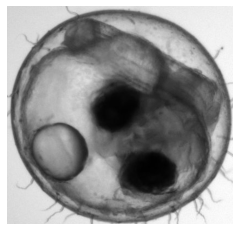

In [5]:
temp0 = image[784:784+400, 946:946+414] # with well 49 
plt.axis("off")
plt.imshow(temp0, cmap="gray")

We can now call `matchTemplates` with this single template image 

In [6]:
# 1st format the template into a list of tuple (label, templateImage)
listTemplate = [('temp0', temp0)]

In [7]:
# Then call the function matchTemplates (here a single template)
%timeit Hits = matchTemplates(listTemplate, image, N_object=4,score_threshold=0.4, method=cv2.TM_CCOEFF_NORMED, maxOverlap=0.3)

1.29 s ± 125 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
Hits = matchTemplates(listTemplate, image, N_object=4,score_threshold=0.4, method=cv2.TM_CCOEFF_NORMED, maxOverlap=0.3)
print("Found {} hits".format( len(Hits.index) ) )
Hits

Found 4 hits


,BBox,Score,TemplateName
2,"(1064, 1238, 414, 400)",0.461289,temp0
3,"(1398, 889, 414, 400)",0.512312,temp0
4,"(946, 784, 414, 400)",1.000000,temp0
6,"(1438, 481, 414, 400)",0.472887,temp0


As you can see, `Hits` is a table (pandas DataFrame) with one row per detection with:
- the name of the template that yield the match
- the coordinates of the bounding box (x, y, width, height)
- the score for that detection  

The first hit in the list has a score of 1 and is the embryo that is used as template.

We can then represent the detections as bounding boxes overlaid on the image.

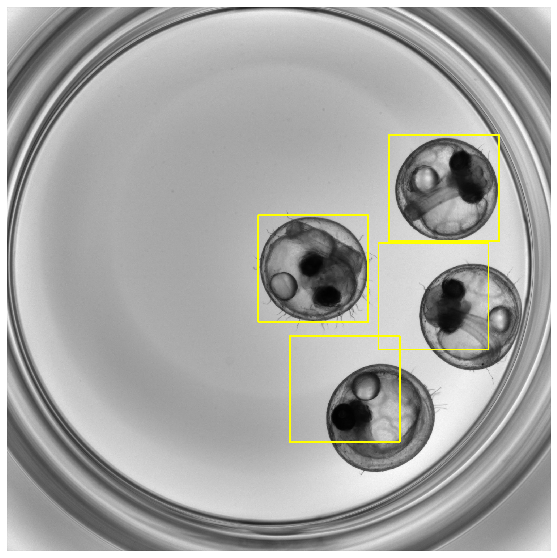

In [11]:
Overlay = drawBoxesOnRGB(image, Hits, boxThickness=5)
plt.figure(figsize = (10,10))
plt.axis("off")
plt.imshow(Overlay)

2 embryos were correctly detected and 2 are included in the bounding box but not completely included.  
This is due to the fact that the template matching matches intensity patterns, ie it will properly find objects that have the same orientation and perspective as in the template.  
To improve the precision of localisation, one can provide more templates (other perspectives...) to search.  

The additional templates can be generated by rotation or flipped (mirroring) of the initial template.  
This is a bit like doing data-augmentation with the template.  

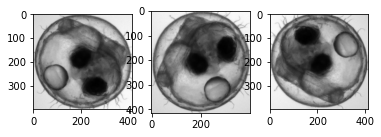

In [6]:
## Perform rotation of the initial template
listTemplate = [("0", temp0)]

# Initialise figure
f, axarr = plt.subplots(1,3)
axarr[0].imshow(temp0, cmap="gray")

for i,angle in enumerate([90,180]):
    rotated = np.rot90(temp0, k=i+1) # NB: np.rotate not good here, turns into float!
    listTemplate.append( (str(angle), rotated ) )
    axarr[i+1].imshow(rotated, cmap="gray")
    
    # We could also do some flipping with np.fliplr, flipud

We now have 3 templates in total.  
We can search each of them and still return the 4 best matches.

In [13]:
%timeit Hits = matchTemplates(listTemplate, image, N_object=4, score_threshold=0.4, method=cv2.TM_CCOEFF_NORMED, maxOverlap=0.3)

3.58 s ± 126 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


,TemplateName,BBox,Score
4,0,"(946, 784, 414, 400)",1.000000
100,180,"(1525, 968, 414, 400)",0.591937
72,180,"(1173, 1354, 414, 400)",0.551068
17,90,"(1459, 474, 400, 414)",0.538105


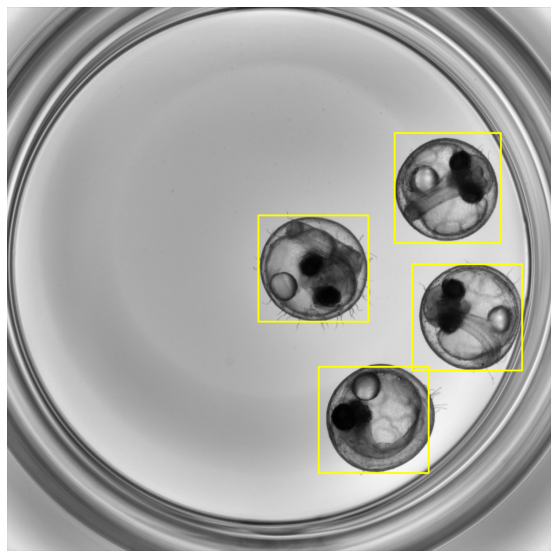

In [7]:
Hits = matchTemplates(listTemplate, image, N_object=4, score_threshold=0.4, method=cv2.TM_CCOEFF_NORMED, maxOverlap=0.3)

Overlay = drawBoxesOnRGB(image, Hits, boxThickness=5)
plt.figure(figsize = (10,10))
plt.axis("off")
plt.imshow(Overlay)

Hits

## NMS in detail

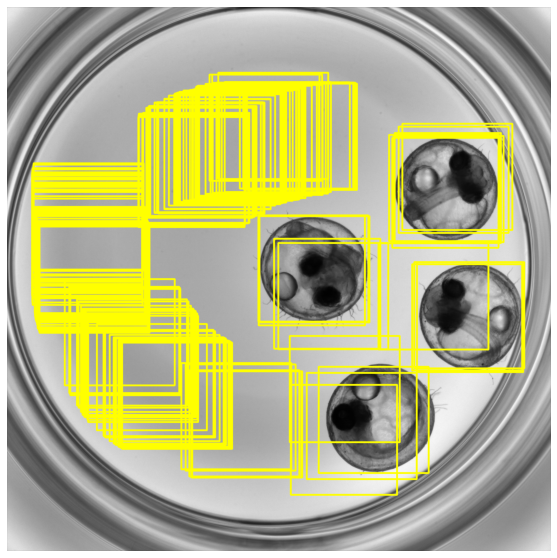

In [8]:
preHits = MTM.findMatches(listTemplate, image, N_object=4, score_threshold=0.4, method=cv2.TM_CCOEFF_NORMED)

Overlay = drawBoxesOnRGB(image, preHits, boxThickness=5)
plt.figure(figsize = (10,10))
plt.axis("off")
plt.imshow(Overlay)

#preHits.to_csv("opencv.csv")
#preHits

In [16]:
finalHits = NMS(preHits, scoreThreshold=0.4, maxOverlap=0.3, N_object=6)
finalHits

,TemplateName,BBox,Score
4,0,"(946, 784, 414, 400)",1.000000
100,180,"(1525, 968, 414, 400)",0.591937
72,180,"(1173, 1354, 414, 400)",0.551068
17,90,"(1459, 474, 400, 414)",0.538105
71,180,"(686, 1367, 414, 400)",0.508057
111,180,"(111, 787, 414, 400)",0.448368


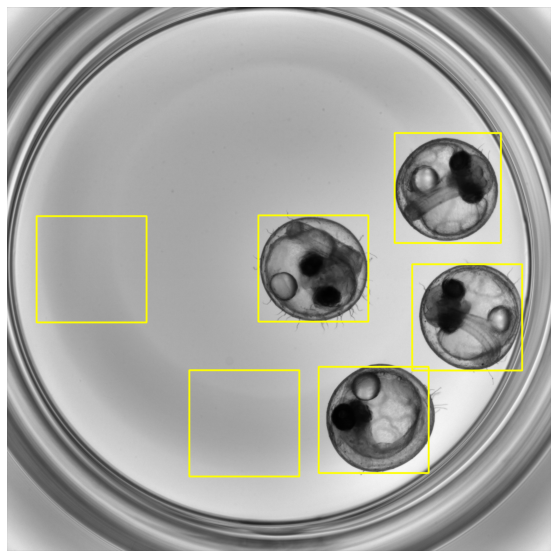

In [17]:
Overlay = drawBoxesOnRGB(image, finalHits, boxThickness=5)
plt.figure(figsize = (10,10))
plt.axis("off")
plt.imshow(Overlay)